# Sentence Level Semantic Frame Identification

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import numpy as np
import json
from conllu import parse
import matplotlib.pyplot as plt

In [3]:
def read_file(file_name):
    with open(file_name, "r", encoding="utf-8") as json_file:
        data = json.load(json_file)
    return data

In [4]:
data_train = read_file('UP_German/de-up-train.conllu.json')
data_dev = read_file('UP_German/de-up-dev.conllu.json')
data_test = read_file('UP_German/de-up-test.conllu.json')

### Number of instances

In [5]:
print("Train data: {}".format(len(data_train)))
print("Dev data: {}".format(len(data_dev)))
print("Test data: {}".format(len(data_test)))

Train data: 21261
Dev data: 1180
Test data: 1317


### Number of unique sentences

In [6]:
def get_no_of_unique_sentences(data):
    sentences_list = [data[instance]['conllu'] for instance in data]
    conllu_sentences = ['\n'.join(sentence) for sentence in sentences_list]
    conllu_data = '\n\n'.join(conllu_sentences)
    token_list = []

    # creating a list of tokens for each sentence
    for tokens in parse(conllu_data):
        token_list.append(np.array(tokens))

    token_list = np.array(token_list)
    
    sentences = []
    for tokens in token_list:
        sentence = []
        for t in tokens:
            sentence.append(t['form'])
        sentences.append(' '.join(sentence))
        
    unique_data = np.unique(sentences)
    return len(unique_data), token_list, sentences

In [7]:
print("Number of unique sentences")
num_unique_train, tokens_list_train, sentences_train = get_no_of_unique_sentences(data_train)
print("Train data: {}".format(num_unique_train))
num_unique_dev, tokens_list_dev, sentences_dev = get_no_of_unique_sentences(data_dev)
print("Dev data: {}".format(num_unique_dev))
num_unique_test, tokens_list_test, sentences_test = get_no_of_unique_sentences(data_test)
print("Test data: {}".format(num_unique_test))

Number of unique sentences
Train data: 12956
Dev data: 717
Test data: 814


Number of unique sentences
Train data: 12956
Dev data: 717
Test data: 814

In [8]:
sentences_train[0]

'Der See wird durch Schnee - und Gletscherschmelzwasser gespeist .'

### Number of unique labels/classes

In [9]:
labels_list_train = [data_train[instance]['label'] for instance in data_train]
labels_list_dev = [data_dev[instance]['label'] for instance in data_dev]
labels_list_test = [data_test[instance]['label'] for instance in data_test]
labels_list = labels_list_train + labels_list_dev + labels_list_test
labels = np.unique(labels_list)
print("Total number of labels: {}".format(len(labels)))

Total number of labels: 1169


### Training histogram - number of labels

In [10]:
train_labels, counts = np.unique(labels_list_train, return_counts=True)
train_labels, counts

(array(['abandon.01', 'abolish.01', 'abort.01', ..., 'wrap.01', 'write.01',
        'yield.01'], dtype='<U16'),
 array([ 3,  6,  9, ...,  4, 72,  5], dtype=int64))

In [11]:
diff = list(set(labels) - set(train_labels))
len(diff)

24

In [12]:
labels_to_plot = np.append(train_labels, diff)
counts = np.append(counts, np.repeat(0, 24))
len(labels_to_plot), len(counts)

(1169, 1169)

In [13]:
max(counts), min(counts)

(4023, 0)

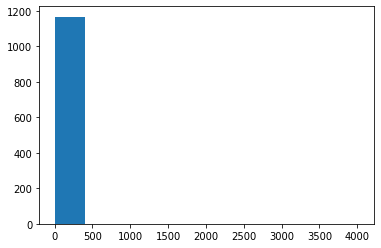

In [14]:
plt.hist(counts)
plt.show()

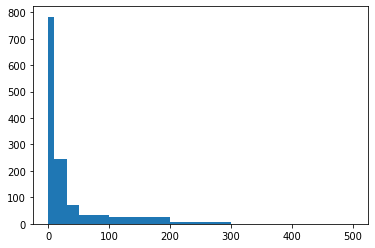

In [15]:
plt.hist(counts, bins=[0, 10, 30, 50, 100, 200, 300, 400, 500])
plt.show()

## Baseline - Naive Bayes with Laplace smoothed unigram likelihood and uniform prior

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

nb = Pipeline([
                ('vect', CountVectorizer()),
               ('clf', MultinomialNB(alpha=1, fit_prior=False)),
              ])

nb.fit(sentences_train, labels_list_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=1, class_prior=None, fit_prior=False))])

In [18]:
y_pred_nb = nb.predict(sentences_dev)

accuracy_nb = accuracy_score(y_pred_nb, labels_list_dev)
print('accuracy {}'.format(accuracy_nb))
precision_nb = precision_score(y_pred_nb, labels_list_dev, average='weighted')
print('precision {}'.format(precision_nb))
recall_nb = recall_score(y_pred_nb, labels_list_dev, average='weighted')
print('recall {}'.format(recall_nb))
f1score_nb = f1_score(y_pred_nb, labels_list_dev, average='weighted')
print('f1 score {}'.format(f1score_nb))

accuracy 0.2245762711864407
precision 0.9807824718141369
recall 0.2245762711864407
f1 score 0.35265705364047517


## Maxent model

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model

### 1. Feature - Count

In [20]:
count_vect = CountVectorizer()
count_features_train = count_vect.fit_transform(sentences_train)
X_train = count_features_train

logreg = linear_model.SGDClassifier(loss='log')
logreg.fit(X_train, labels_list_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [21]:
count_features_dev = count_vect.transform(sentences_dev)
X_dev = count_features_dev
y_pred_counts = logreg.predict(X_dev)

accuracy_counts = accuracy_score(y_pred_counts, labels_list_dev)
print('accuracy {}'.format(accuracy_counts))
precision_counts = precision_score(y_pred_counts, labels_list_dev, average='weighted')
print('precision {}'.format(precision_counts))
recall_counts = recall_score(y_pred_counts, labels_list_dev, average='weighted')
print('recall {}'.format(recall_counts))
f1score_counts = f1_score(y_pred_counts, labels_list_dev, average='weighted')
print('f1 score {}'.format(f1score_counts))

accuracy 0.3855932203389831
precision 0.6905656643270416
recall 0.3855932203389831
f1 score 0.4614758706656223


### 2. Feature - is_capitalize

In [22]:
from sklearn.pipeline import FeatureUnion, Pipeline

In [23]:
def is_capitalize_feature_func(sentence):
    tokens = sentence.split(" ")
    features = []
    for token in tokens:
        if token.istitle():
            features.append(1)
        else:
            features.append(0)
    return np.asarray(features)

In [24]:
def pipelinize_feature(function):
    def list_comprehend_a_function(sentences_list):
        if active:
            processed = [function(sentence) for sentence in sentences_list]
            return np.asarray(processed)
        else:
            return np.zeros(len(sentences_list))

In [25]:
pipeline_iscap = Pipeline([
        ('features', FeatureUnion([
                    ('vectorizer', CountVectorizer()),
                    ('is_capitalize', pipelinize_feature(is_capitalize_feature_func))
                ])),
        ('classifier', linear_model.SGDClassifier(loss='log'))
    ])

pipeline_iscap.fit(sentences_train, labels_list_train)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
       ...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [26]:
y_pred_iscap = pipeline_iscap.predict(sentences_dev)

accuracy_iscap = accuracy_score(y_pred_iscap, labels_list_dev)
print('accuracy {}'.format(accuracy_iscap))
precision_iscap = precision_score(y_pred_iscap, labels_list_dev, average='weighted')
print('precision {}'.format(precision_iscap))
recall_iscap = recall_score(y_pred_iscap, labels_list_dev, average='weighted')
print('recall {}'.format(recall_iscap))
f1score_iscap = f1_score(y_pred_iscap, labels_list_dev, average='weighted')
print('f1 score {}'.format(f1score_iscap))

accuracy 0.37796610169491524
precision 0.6796950657956812
recall 0.37796610169491524
f1 score 0.44614324557694746


### 3. Features - count and is_verb 

In [27]:
def is_verb_feature_func(annot_list):
    features = []
    for annot in annot_list:
        if annot == 'VERB':
            features.append(1)
        else:
            features.append(0)
    return np.asarray(features)

In [28]:
def pipelinize_feature_2(function, annot_list):
    def list_comprehend_a_function(sentence_list, annot_list):
        if active:
            processed = [function(annots) for annots in annot_list]
            return np.asarray(processed)
        else:
            return np.zeros(len(sentences_list))

In [29]:
annot_list_upostag_train = []
for token_list in tokens_list_train:
    annots = []
    for token in token_list:
        annots.append(token['upostag'])
    annot_list_upostag_train.append(annots)
annot_list_upostag_train[0]

['DET', 'NOUN', 'AUX', 'ADP', 'NOUN', 'PUNCT', 'CONJ', 'NOUN', 'VERB', 'PUNCT']

In [30]:
pipeline_isverb = Pipeline([
        ('features', FeatureUnion([
                    ('vectorizer', CountVectorizer()),
                    ('is_verb', pipelinize_feature_2(is_verb_feature_func, annot_list_upostag_train))
                ])),
        ('classifier', linear_model.SGDClassifier(loss='log'))
    ])

pipeline_isverb.fit(sentences_train, labels_list_train)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
       ...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [31]:
y_pred_isverb = pipeline_isverb.predict(sentences_dev)

accuracy_isverb = accuracy_score(y_pred_isverb, labels_list_dev)
print('accuracy {}'.format(accuracy_isverb))
precision_isverb = precision_score(y_pred_isverb, labels_list_dev, average='weighted')
print('precision {}'.format(precision_isverb))
recall_isverb = recall_score(y_pred_isverb, labels_list_dev, average='weighted')
print('recall {}'.format(recall_isverb))
f1score_isverb = f1_score(y_pred_isverb, labels_list_dev, average='weighted')
print('f1 score {}'.format(f1score_isverb))

accuracy 0.3805084745762712
precision 0.6868254337572521
recall 0.3805084745762712
f1 score 0.45707459989478255


### 4. Features - count and syntax

In [32]:
def syntax_feature_func(annot_list):
    features = []
    for annot in annot_list:
        if annot in ['root', 'nmod']:
            features.append(1)
        else:
            features.append(0)
    return np.asarray(features)

In [33]:
annot_list_syntax_train = []
for token_list in tokens_list_train:
    annots = []
    for token in token_list:
        annots.append(token['deprel'])
    annot_list_syntax_train.append(annots)
annot_list_syntax_train[0]

['det',
 'nsubjpass',
 'auxpass',
 'case',
 'nmod',
 'punct',
 'cc',
 'conj',
 'root',
 'punct']

In [34]:
pipeline_syntax = Pipeline([
        ('features', FeatureUnion([
                    ('vectorizer', CountVectorizer()),
                    ('syntax', pipelinize_feature_2(syntax_feature_func, annot_list_syntax_train))
                ])),
        ('classifier', linear_model.SGDClassifier(loss='log'))
    ])

pipeline_syntax.fit(sentences_train, labels_list_train)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
       ...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [35]:
y_pred_syntax = pipeline_syntax.predict(sentences_dev)

accuracy_syntax = accuracy_score(y_pred_syntax, labels_list_dev)
print('accuracy {}'.format(accuracy_syntax))
precision_syntax = precision_score(y_pred_syntax, labels_list_dev, average='weighted')
print('precision {}'.format(precision_syntax))
recall_syntax = recall_score(y_pred_syntax, labels_list_dev, average='weighted')
print('recall {}'.format(recall_syntax))
f1score_syntax = f1_score(y_pred_syntax, labels_list_dev, average='weighted')
print('f1 score {}'.format(f1score_syntax))

accuracy 0.38728813559322034
precision 0.704829471074681
recall 0.38728813559322034
f1 score 0.46596541960075144


### 5. Features - count, syntax and upos

In [36]:
pipeline_combined = Pipeline([
        ('features', FeatureUnion([
                    ('vectorizer', CountVectorizer()),
                    ('is_verb', pipelinize_feature_2(is_verb_feature_func, annot_list_upostag_train)),
                    ('syntax', pipelinize_feature_2(syntax_feature_func, annot_list_syntax_train))
                ])),
        ('classifier', linear_model.SGDClassifier(loss='log'))
    ])

pipeline_combined.fit(sentences_train, labels_list_train)

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=None,
       transformer_list=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
       ...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [37]:
y_pred_combined = pipeline_combined.predict(sentences_dev)

accuracy_combined = accuracy_score(y_pred_combined, labels_list_dev)
print('accuracy {}'.format(accuracy_combined))
precision_combined = precision_score(y_pred_combined, labels_list_dev, average='weighted')
print('precision {}'.format(precision_combined))
recall_combined = recall_score(y_pred_combined, labels_list_dev, average='weighted')
print('recall {}'.format(recall_combined))
f1score_combined = f1_score(y_pred_combined, labels_list_dev, average='weighted')
print('f1 score {}'.format(f1score_combined))

accuracy 0.39322033898305087
precision 0.7015211698969906
recall 0.39322033898305087
f1 score 0.4740516176619486


## Internal development plot

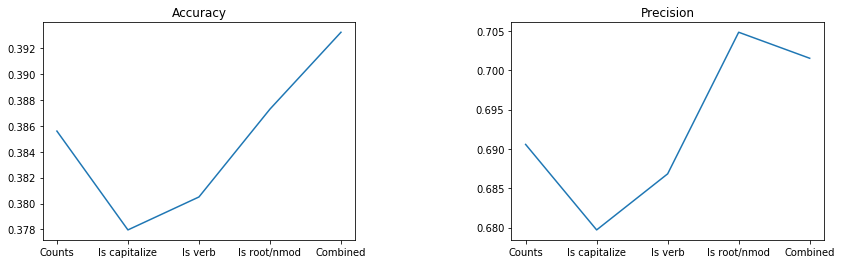

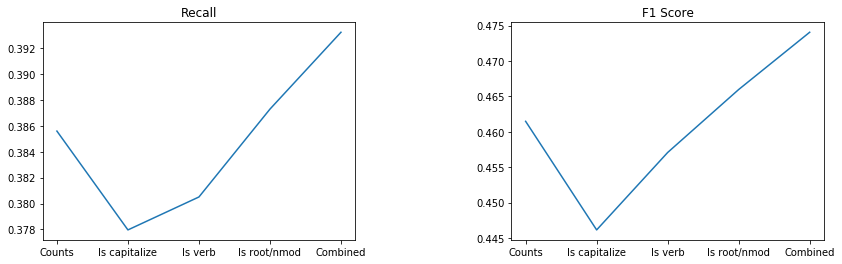

In [38]:
fig = plt.figure(figsize=(14, 4))
fig.subplots_adjust(wspace=0.5)

plt.subplot(121)
plt.title('Accuracy')
plt.plot(['Counts', 'Is capitalize', 'Is verb', 'Is root/nmod', 'Combined'], 
         [accuracy_counts, accuracy_iscap, accuracy_isverb, accuracy_syntax, accuracy_combined])

plt.subplot(122)
plt.title('Precision')
plt.plot(['Counts', 'Is capitalize', 'Is verb', 'Is root/nmod', 'Combined'], 
         [precision_counts, precision_iscap, precision_isverb, precision_syntax, precision_combined])

fig = plt.figure(figsize=(14, 4))
fig.subplots_adjust(wspace=0.5)

plt.subplot(121)
plt.title('Recall')
plt.plot(['Counts', 'Is capitalize', 'Is verb', 'Is root/nmod', 'Combined'], 
         [recall_counts, recall_iscap, recall_isverb, recall_syntax, recall_combined])

plt.subplot(122)
plt.title('F1 Score')
plt.plot(['Counts', 'Is capitalize', 'Is verb', 'Is root/nmod', 'Combined'], 
         [f1score_counts, f1score_iscap, f1score_isverb, f1score_syntax, f1score_combined])

plt.show()

## Test results on baseline NB and maxent model with syntax features

In [39]:
y_pred_nb_test = nb.predict(sentences_test)

accuracy_nb_test = accuracy_score(y_pred_nb_test, labels_list_test)
print('accuracy {}'.format(accuracy_nb_test))
precision_nb_test = precision_score(y_pred_nb_test, labels_list_test, average='weighted')
print('precision {}'.format(precision_nb_test))
recall_nb_test = recall_score(y_pred_nb_test, labels_list_test, average='weighted')
print('recall {}'.format(recall_nb_test))
f1score_nb_test = f1_score(y_pred_nb_test, labels_list_test, average='weighted')
print('f1 score {}'.format(f1score_nb_test))

accuracy 0.18223234624145787
precision 0.9792001700316051
recall 0.18223234624145787
f1 score 0.29270905555296817


In [80]:
y_pred_combined_test = pipeline_combined.predict(sentences_test)

accuracy_combined_test = accuracy_score(y_pred_combined_test, labels_list_test)
print('accuracy {}'.format(accuracy_combined_test))
precision_combined_test = precision_score(y_pred_combined_test, labels_list_test, average='weighted')
print('precision {}'.format(precision_combined_test))
recall_combined_test = recall_score(y_pred_combined_test, labels_list_test, average='weighted')
print('recall {}'.format(recall_combined_test))
f1score_combined_test = f1_score(y_pred_combined_test, labels_list_test, average='weighted')
print('f1 score {}'.format(f1score_combined_test))

accuracy 0.3545937737281701
precision 0.6984457226280043
recall 0.3545937737281701
f1 score 0.43351555255950897


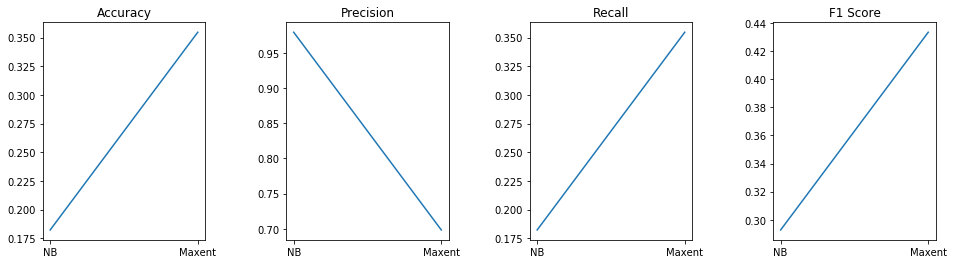

In [81]:
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(wspace=0.5)
plt.subplot(141)
plt.title('Accuracy')
plt.plot(['NB', 'Maxent'], 
         [accuracy_nb_test, accuracy_combined_test])

plt.subplot(142)
plt.title('Precision')
plt.plot(['NB', 'Maxent'], 
         [precision_nb_test, precision_combined_test])

plt.subplot(143)
plt.title('Recall')
plt.plot(['NB', 'Maxent'], 
         [recall_nb_test, recall_combined_test])

plt.subplot(144)
plt.title('F1 Score')
plt.plot(['NB', 'Maxent'], 
         [f1score_nb_test, f1score_combined_test])

plt.show()

The accuracy of the combined maxent model is 35.45% which is significantly higher than baseline model which gives 18.22%. Same for the recall and f1 score, maxent model gives higher scores. On the contrary, the precision is higher for baseline but then the recall is very low so having high precision only does not mean that the model’s performance is very good.

## 20 most extreme weights

In [82]:
sgd_clf = pipeline_combined.named_steps['classifier']
features_vect = pipeline_combined.named_steps['features']

In [86]:
feature_names = features_vect.get_feature_names()
classes = sgd_clf.classes_[:5]
for i, class_label in enumerate(classes):
    top20 = np.argsort(sgd_clf.coef_[i])[-20:]
    print("{}: {}".format(class_label, " ".join(feature_names[j] for j in top20)))
    print()

abandon.01: vectorizer__intensiven vectorizer__merkur vectorizer__frühzeit vectorizer__himmelskörper vectorizer__sonnennächster vectorizer__zwar vectorizer__125 vectorizer__gestein vectorizer__temperaturen vectorizer__problematisch vectorizer__messergebnis vectorizer__argon vectorizer__verfälscht vectorizer__entweichen vectorizer__qualität vectorizer__arbeit vectorizer__hoch vectorizer__exorbitant vectorizer__auszusetzen vectorizer__ausgesetzt

abolish.01: vectorizer__wehrpflicht vectorizer__besatzung vectorizer__bayrischen vectorizer__1806 vectorizer__wolfurt vectorizer__hofsteig vectorizer__niedergericht vectorizer__jahrhundertealte vectorizer__ziel vectorizer__fluss vectorizer__bewegung vectorizer__züchtigungsrecht vectorizer__gesetzesänderung vectorizer__elterliche vectorizer__bundesstaat vectorizer__chartisten vectorizer__abzuschaffen vectorizer__getreidegesetze vectorizer__sklaverei vectorizer__abgeschafft

abort.01: vectorizer__pietatis vectorizer__hauptanstalt vectorizer__versa

The most extreme features of our combined features maxent model are represented per class. Among which, the 20 most extreme feature weights of the alphabetically first 5 classes are observed. The first label abandon.01 has higher weights for features such as intensiven, merkur, frühzeit, etc., which fire for this frame in the train set. Same is true for the most of the labels, but there are instances which have the same features with the same annotations but the semantic frame is different. These predictions have a chance of improvment if higher order n-grams are considered so that the context of the word and the annotations of the context words might help identify the label correctly.